In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Sommaire <a class='anchor' id='S'></a>

## [I, Preprocessing des datas](#I)

### [A, DF train et test](#IA)
### [B, Bureau and balances](#IB)
### [C, Previous application](#IC)
### [D, POS_cash_balance](#ID)
### [E, installments payment](#IE)
### [F, credit_card_balance](#IF)
### [G, Jonction des datas](#IG)

## [II, Recherche d'un modèle de prédiction](#II)

### [A, Mise en place d'un jeu d'entrainement et de test équilibré avec SMOTE](#IIA)
### [B, Recherche d'un algorithme pertinent](#IIB)
#### [Regression logistic](#IIB1)
#### [Random forest](#IIB2)
#### [LIght BMC](#IIB3)

### [C, Amélioration de l'algorithme](#IIC)
#### [Recherche d'hyperparamètres avec HalvingSearchCV](#IIC1)
#### [Recherche du threshold pertinent](#IIC2)

### [D, Analyse de l'importance des features locales](#IID) 
#### [Avec LIME](#IID1)
#### [Avec SHAP](#IID2)

## [III, Export du modèle de prediction](#III)

##### [fin de page](#fdp)


#### [checkpoint](#C)

# I, Preprocessing des datas <a class='anchor' id='I'></a>

In [2]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)    
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
def binary_encoder(df, nan_as_category = True):
    for c in df.columns:
        if len(df[c].unique()) == 2:
            df[c], uniques = pd.factorize(df[c])

## A, DF train et test <a class='anchor' id='IA'></a>

In [4]:
train = pd.read_csv('data/application_train.csv')
test = pd.read_csv('data/application_test.csv')

In [5]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [6]:
df = pd.concat([train, test], axis=0)

In [7]:
df.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
20038,245577,NaN,Cash loans,F,Y,N,0,90000.0,729792.0,30919.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
284540,429535,0.0,Cash loans,M,N,Y,0,180000.0,254700.0,24808.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
85314,198982,1.0,Cash loans,M,N,Y,0,180000.0,450000.0,36081.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.CODE_GENDER.value_counts()

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

In [9]:
df = df[df.CODE_GENDER != 'XNA']

In [10]:
len(df.CODE_GENDER.unique())

2

In [11]:
#Categorical features binary and one hot encoder
binary_encoder(df)
df, cat_cols = one_hot_encoder(df)

In [12]:
df.shape

(356251, 253)

In [13]:
df['DAYS_EMPLOYED'].value_counts()[:5]

 365243    64648
-200         175
-199         171
-212         165
-224         163
Name: DAYS_EMPLOYED, dtype: int64

In [14]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [15]:
# new features :
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

In [16]:
df.shape

(356251, 258)

In [17]:
df.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
163781,289860,0.0,0,0,0,0,0,180000.0,755190.0,38686.5,...,0,0,1,0,0,0.044211,0.238351,90000.0,0.214925,0.051228
294400,441071,0.0,0,1,1,0,3,112500.0,206059.5,17815.5,...,0,1,0,0,1,0.140709,0.545959,22500.0,0.158360,0.086458
105146,222008,0.0,0,1,0,1,0,180000.0,640080.0,23121.0,...,0,0,1,0,0,0.307441,0.281215,180000.0,0.128450,0.036122


##### [sommaire](#S)

## B, Bureau and balances <a class='anchor' id='IB'></a>

In [18]:
bureau = pd.read_csv('data/bureau.csv')
bb = pd.read_csv('data/bureau_balance.csv')

In [19]:
bureau.shape, bb.shape

((1716428, 17), (27299925, 3))

In [20]:
bureau.sample(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
926562,426194,5119741,Active,currency 1,-335,0,761.0,NaN,0.0,0,363793.5,294439.5,0.0,0.0,Consumer credit,-32,NaN
475769,256311,5108355,Closed,currency 1,-1006,0,-889.0,-889.0,NaN,0,1125000.0,0.0,0.0,0.0,Consumer credit,-602,NaN
565118,398546,5672183,Closed,currency 1,-500,0,-316.0,-347.0,0.0,0,25285.5,0.0,0.0,0.0,Consumer credit,-347,NaN


In [21]:
bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)

In [22]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bb, bb_agg

In [23]:
bureau.shape

(1716428, 51)

In [24]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

In [25]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [26]:
bureau.shape

(1716428, 51)

In [27]:
bureau.sample(3)

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
1002728,313212,-447,0,283.0,NaN,NaN,0,585859.5,274234.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
961897,392810,-788,0,-423.0,-423.0,NaN,0,72796.5,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216855,430227,-782,0,-52.0,-51.0,NaN,0,675000.0,0.0,0.0,...,26.0,0.923077,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0


In [28]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg

In [29]:
bureau_agg.shape

(305811, 89)

In [30]:
bureau_agg.sample(3)

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
373191,-1669,-1078,-1422.000000,94377.000000,-1394.0,307.0,-660.666667,-769.666667,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
142470,-1450,-1450,-1450.000000,NaN,-1238.0,-1238.0,-1238.000000,-1267.000000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225026,-1871,-1162,-1429.666667,148290.333333,-1070.0,-775.0,-932.000000,-794.000000,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg, bureau

In [32]:
bureau_agg.shape

(305811, 116)

In [33]:
bureau_agg.sample(3)

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
252856,-520,-324,-422.000000,19208.000000,-155.0,1502.0,673.500000,-83.5,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
189953,-2406,-343,-1524.666667,540373.066667,-580.0,1483.0,123.166667,-682.5,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
183996,-1779,-1779,-1779.000000,NaN,-1424.0,-1424.0,-1424.000000,-1037.0,0,0.0,...,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0


##### [sommaire](#S)

## C, Previous application <a class='anchor' id='IC'></a>

In [34]:
prev = pd.read_csv('data/previous_application.csv')

In [35]:
prev.shape

(1670214, 37)

In [36]:
prev.sample(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1534365,1312218,426016,Consumer loans,11089.80,58500.0,55255.5,5850.0,58500.0,TUESDAY,6,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-2505.0,-2355.0,-2355.0,-2348.0,1.0
219924,1671236,257921,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,15,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1524727,1642042,239232,Consumer loans,9004.59,88933.5,98325.0,0.0,88933.5,SUNDAY,14,...,Jewelry,12.0,low_action,POS others without interest,365243.0,-121.0,209.0,365243.0,365243.0,0.0


In [37]:
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

In [38]:
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [39]:
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

In [40]:
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

In [41]:
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

In [42]:
prev_agg.shape

(338857, 189)

In [43]:
prev_agg.sample(3)

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_PRODUCT_COMBINATION_nan_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
306638,16047.945,49461.210,25895.007000,0.0,450000.0,158901.000000,0.0,470790.0,235922.250000,0.000000,...,0.166667,0.166667,0.166667,0.00,0.0,0.166667,0.0,0.0,0.0,0.0
281901,16663.455,36868.815,26877.072857,0.0,1269000.0,410727.272727,0.0,1453257.0,452722.909091,0.834725,...,0.363636,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0
387067,10489.500,15001.155,12745.327500,0.0,225000.0,76413.375000,0.0,225000.0,77477.625000,0.949865,...,0.250000,0.000000,0.000000,0.25,0.0,0.000000,0.0,0.0,0.0,0.0


In [44]:
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

In [45]:
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev

In [46]:
prev_agg.shape

(338857, 249)

In [47]:
prev_agg.sample(3)

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
126543,5801.085,13232.34,8744.7825,0.000,225000.000,62306.070,0.0,312304.5,76523.25,0.720451,...,13.0,13.0,NaN,NaN,NaN,-292.0,-292.0,-292.0,NaN,0.0
105560,4099.275,11906.19,8002.7325,38826.000,176575.500,107700.750,34213.5,199300.5,116757.00,0.885976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445679,10042.470,10042.47,10042.4700,97959.375,97959.375,97959.375,97956.0,97956.0,97956.00,1.000034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### [sommaire](#S)

### D, POS_cash_balance <a class='anchor' id='ID'></a>

In [48]:
pos = pd.read_csv('data/POS_CASH_balance.csv')

In [49]:
pos.shape

(10001358, 8)

In [50]:
pos.sample(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
5115957,2208369,283054,-1,36.0,4.0,Active,0,0
7751394,2552170,372441,-69,21.0,3.0,Active,0,0
754925,1849694,434879,-31,24.0,24.0,Active,0,0


In [51]:
pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

In [52]:
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}

In [53]:
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

In [54]:
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos

In [55]:
pos_agg.shape

(337252, 18)

In [56]:
pos_agg.sample(3)

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
295003,-1,-12.500000,24,0,0.000000,0,0.000000,0.958333,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,24
190558,-44,-60.378378,37,0,0.000000,0,0.000000,0.972973,0.0,0.0,0.0,0.027027,0.0,0.0,0.0,0.0,0.0,37
290888,-1,-13.500000,26,1,0.076923,1,0.076923,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,26


##### [sommaire](#S)

### E, installments payment <a class='anchor' id='IE'></a>

In [57]:
ins = pd.read_csv('data/installments_payments.csv')

In [58]:
ins.shape

(13605401, 8)

In [59]:
ins.sample(3)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
5190748,2074774,279233,1.0,4,-525.0,-531.0,9892.080,9892.080
6173835,1277362,282150,2.0,24,-371.0,-402.0,17974.575,632.565
19413,2287931,150056,0.0,27,-761.0,-756.0,19599.975,19599.975


In [60]:
ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)

In [61]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

In [62]:
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

In [63]:
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}

In [64]:
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

In [65]:
ins_agg.shape

(339587, 25)

In [66]:
ins_agg.sample(3)

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
146101,3,12.0,0.514286,18.0,46.0,16.257143,569.0,1.0,0.914286,32.0,...,14890.95,5402.076429,189072.675,60.030,14890.95,4907.985429,171779.49,-36.0,-231.657143,-8108.0
184662,2,0.0,0.000000,0.0,10.0,7.142857,50.0,1.0,1.000000,7.0,...,24177.87,14029.572857,98207.010,12338.190,24177.87,14029.572857,98207.01,-83.0,-176.142857,-1233.0
447820,2,15.0,1.633333,49.0,182.0,31.066667,932.0,1.0,0.800000,24.0,...,9039.87,6636.567000,199097.010,294.885,9039.87,4999.608000,149988.24,-30.0,-1301.100000,-39033.0


##### [sommaire](#S)

### F, credit_card_balance <a class='anchor' id='IF'></a>

In [67]:
cc = pd.read_csv('data/credit_card_balance.csv')

In [68]:
cc.shape

(3840312, 23)

In [69]:
cc.sample(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2024478,2439032,278606,-4,143485.380,225000,0.0,22185.0,0.0,22185.0,7577.775,...,143485.380,143485.380,0.0,1,0.0,1.0,6.0,Active,0,0
1214833,2347769,406197,-8,347019.255,337500,3150.0,3870.0,0.0,720.0,17593.245,...,345673.755,345673.755,1.0,2,0.0,1.0,14.0,Active,0,0
1245765,1444466,215657,-84,73693.530,180000,2250.0,2250.0,0.0,0.0,4500.000,...,73693.530,73693.530,1.0,1,0.0,0.0,11.0,Active,0,0


In [70]:
cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)

In [71]:
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

In [72]:
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
del cc

In [73]:
cc_agg.shape

(103558, 141)

In [74]:
cc_agg.sample(3)

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
191567,-39,-2,-20.5,-779,123.500000,0.0,0.0,0.000000,0.000,0.000000e+00,...,0,0.0000,0,0.0000,0,0,0.0,0,0.0,38
350237,-17,-2,-9.5,-152,22.666667,0.0,11699.1,785.202188,12563.235,8.495590e+06,...,1,0.0625,1,0.0625,0,0,0.0,0,0.0,16
310384,-10,-2,-6.0,-54,7.500000,0.0,0.0,0.000000,0.000,0.000000e+00,...,0,0.0000,0,0.0000,0,0,0.0,0,0.0,9


##### [sommaire](#S)

### G, Jonction des datas <a class='anchor' id='IG'></a>

In [75]:
data = df.merge(bureau_agg, how='left', on='SK_ID_CURR')
data = data.merge(prev_agg, how='left', on='SK_ID_CURR')
data = data.merge(pos_agg, how='left', on='SK_ID_CURR')
data = df.merge(ins_agg, how='left', on='SK_ID_CURR')
data = df.merge(cc_agg, how='left', on='SK_ID_CURR')

In [76]:
data.shape

(356251, 399)

In [77]:
data.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
188327,318340,0.0,1,1,0,1,0,135000.0,337500.0,16875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215259,349438,0.0,0,1,0,1,0,135000.0,213948.0,12411.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310941,124195,NaN,0,1,0,0,1,67500.0,49500.0,5202.0,...,1.0,0.071429,1.0,0.071429,0.0,0.0,0.0,0.0,0.0,14.0


In [78]:
data.sample(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
179664,308207,0.0,0,1,0,0,0,157500.0,668304.0,29565.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299739,447254,0.0,0,1,0,1,0,99000.0,552555.0,16879.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318332,178620,NaN,0,0,1,0,0,157500.0,286704.0,22779.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
data.isna().sum()

SK_ID_CURR                               0
TARGET                               48744
NAME_CONTRACT_TYPE                       0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX     252693
CC_NAME_CONTRACT_STATUS_nan_MEAN    252693
CC_NAME_CONTRACT_STATUS_nan_SUM     252693
CC_NAME_CONTRACT_STATUS_nan_VAR     253385
CC_COUNT                            252693
Length: 399, dtype: int64

In [80]:
data.isna().sum().sum(), (data.isna().sum().sum() / (data.shape[0]*data.shape[1]))*100

(46377785, 32.627290905938025)

In [81]:
data.CC_NAME_CONTRACT_STATUS_nan_MAX.unique()

array([nan,  0.])

In [82]:
for c in data.columns:
    if (len(data[c].unique()) < 5) & (data[c].isna().sum() > 0):
        print(c)
        print(data[c].unique())
        print('-----------------------------------------')

TARGET
[ 1.  0. nan]
-----------------------------------------
CC_CNT_DRAWINGS_OTHER_CURRENT_MIN
[nan  0.  2.  1.]
-----------------------------------------
CC_SK_DPD_MIN
[ nan   0. 458.]
-----------------------------------------
CC_SK_DPD_DEF_MIN
[ nan   0. 458.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Active_MIN
[nan  1.  0.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Active_MAX
[nan  1.  0.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Approved_MIN
[nan  0.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Approved_MAX
[nan  0.  1.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Approved_SUM
[nan  0.  1.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Completed_MIN
[nan  0.  1.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Completed_MAX
[nan  0.  1.]
-----------------------------------------
CC_NAME_CONTRACT_STATUS_Demand_MIN
[nan  0.  1.]

In [83]:
data[data.duplicated('SK_ID_CURR')]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT


In [84]:
data.TARGET.value_counts(dropna=False)

0.0    282682
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

In [85]:
data = data[data.TARGET.notna()]

In [86]:
data = data.set_index('SK_ID_CURR', drop=True)

In [87]:
data_x = data.drop('TARGET', axis=1)

In [88]:
def supp_nan(df):
    for c in df.columns:
        if len(df[c].unique()) < 5:
            df[c], uniques = pd.factorize(df[c])
        elif (len(df[c].unique()) >= 5) & (df[c].isna().sum() > 0):
            df[c].fillna(df[c].mean(), inplace=True)
    return df

In [89]:
data_x = supp_nan(data_x)

In [90]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

data_scaled = mms.fit_transform(data_x)

In [91]:
data_scaled = pd.DataFrame(data_scaled, index=data_x.index, columns=data_x.columns)

In [92]:
data_scaled['TARGET'] = data['TARGET']

In [93]:
colonnes = []
for i in data_scaled.columns:
    if len(data_scaled[i].unique()) == 1:
        print(i)
        print(data_scaled[i].unique())
        colonnes.append(i)

NAME_INCOME_TYPE_nan
[0.]
NAME_EDUCATION_TYPE_nan
[0.]
NAME_FAMILY_STATUS_nan
[0.]
NAME_HOUSING_TYPE_nan
[0.]
WEEKDAY_APPR_PROCESS_START_nan
[0.]
ORGANIZATION_TYPE_nan
[0.]


In [94]:
data_scaled = data_scaled.loc[:,~data_scaled.columns.isin(colonnes)]

In [95]:
for i in data_scaled.columns:
    if '_nan' in i:
        new_i = i.replace('_nan', '')
        print(new_i)
        data_scaled.rename(columns={i: new_i},inplace=True)

NAME_TYPE_SUITE
OCCUPATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
CC_NAME_CONTRACT_STATUS_MIN
CC_NAME_CONTRACT_STATUS_MAX
CC_NAME_CONTRACT_STATUS_MEAN
CC_NAME_CONTRACT_STATUS_SUM
CC_NAME_CONTRACT_STATUS_VAR


In [96]:
data_scaled.sample(3)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_MIN,CC_NAME_CONTRACT_STATUS_MAX,CC_NAME_CONTRACT_STATUS_MEAN,CC_NAME_CONTRACT_STATUS_SUM,CC_NAME_CONTRACT_STATUS_VAR,CC_COUNT,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
337610,0.0,1.0,0.0,0.0,0.052632,0.000819,0.314607,0.138698,0.315376,0.063128,...,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.078534,1.0
392394,1.0,1.0,0.0,0.0,0.000000,0.000935,0.084270,0.068287,0.085297,0.421848,...,0.003738,0.001845,0.006139,0.0,0.0,0.0,0.0,0.0,0.189234,0.0
138452,0.0,1.0,0.0,0.0,0.000000,0.001320,0.023596,0.032889,0.024691,0.118752,...,0.003738,0.001845,0.006139,0.0,0.0,0.0,0.0,0.0,0.189234,0.0


In [97]:
import re
data_scaled = data_scaled.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [98]:
data_scaled.TARGET.value_counts(dropna=False)

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [99]:
data_scaled[data_scaled.TARGET.isna()]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_MIN,CC_NAME_CONTRACT_STATUS_MAX,CC_NAME_CONTRACT_STATUS_MEAN,CC_NAME_CONTRACT_STATUS_SUM,CC_NAME_CONTRACT_STATUS_VAR,CC_COUNT,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,


In [100]:
#data_scaled.to_csv('data_scaled.csv')

# Checkpoint <a class='anchor' id='C'></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_scaled = pd.read_csv('data_scaled.csv', index_col=0)

###### [sommaire](#S)

# II, Recherche d'un modèle de prédiction <a class='anchor' id='II'></a>

## A, Mise en place d'un jeu d'entrainement et de test équilibré avec SMOTE <a class='anchor' id='IIA'></a>

In [3]:
data_trainable = data_scaled[data_scaled.TARGET.notnull()]
X = data_trainable.drop('TARGET', axis=1)
y = data_trainable.TARGET

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((246005, 391), (246005,), (61502, 391), (61502,))

In [6]:
y_train.value_counts(), y_test.value_counts()

(0.0    226145
 1.0     19860
 Name: TARGET, dtype: int64,
 0.0    56537
 1.0     4965
 Name: TARGET, dtype: int64)

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

In [8]:
y_train.value_counts()

0.0    226145
1.0    226145
Name: TARGET, dtype: int64

##### [sommaire](#S)

## B, Recherche d'un algorithme pertinent <a class='anchor' id='IIB'></a>

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, adjusted_rand_score, precision_recall_fscore_support, fbeta_score, make_scorer, recall_score, roc_curve, roc_auc_score

In [122]:
def scoring_perso(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    score2 = 1 - ((10*fp + fn - 5*tp) / cm.sum())
    return score2

In [123]:
score_beta = make_scorer(scoring_perso, greater_is_better=True)

##### [sommaire](#S)

### Logistic Regression <a class='anchor' id='IIB1'></a>

In [12]:
lr = LogisticRegression(max_iter=500)

In [13]:
%%time
lr.fit(X_train, y_train)

Wall time: 1min 27s


C:\Users\Alex\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

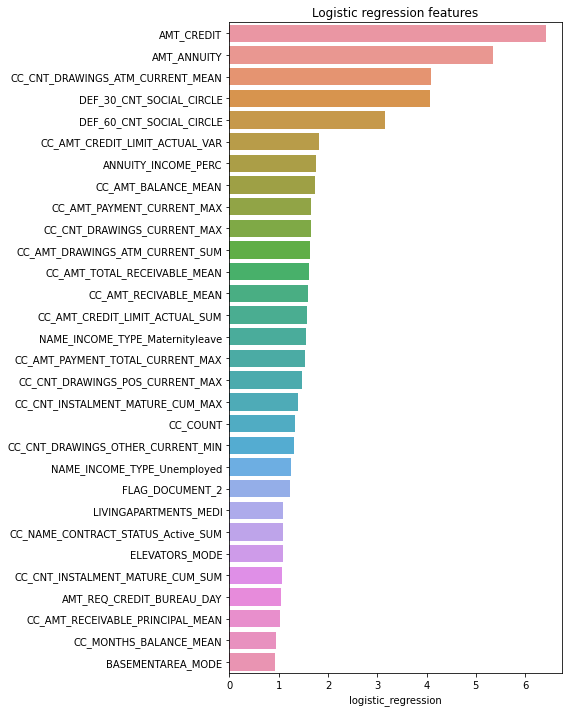

In [14]:
coefficients = pd.DataFrame(lr.coef_, columns=X.columns, index=['logistic_regression']).T
coefficients = coefficients.sort_values(by='logistic_regression', ascending=False)[:30]

plt.figure(figsize=(8,10))
sns.barplot(y=coefficients.index, x='logistic_regression', data=coefficients)
plt.title('Logistic regression features')
plt.tight_layout()
#plt.savefig("lr_features.png", bbox_inches='tight', transparent=True)
plt.show()

In [15]:
y_pred_lr = lr.predict(X_test)

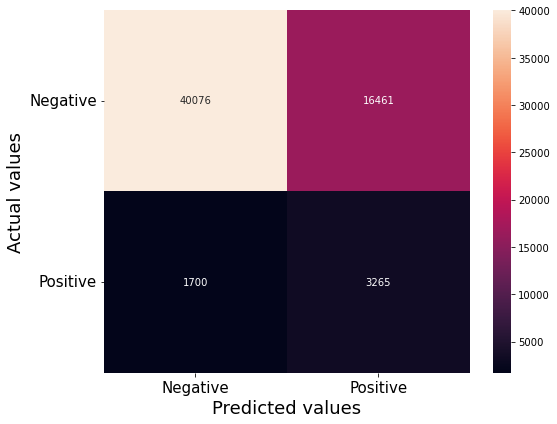

Sensitivity : 65.76 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 70.88 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 16.55 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : -0.31


In [16]:
cm = confusion_matrix(y_test, y_pred_lr)

cm = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted values', fontsize=18)
plt.ylabel('Actual values', fontsize=18)
plt.yticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.xticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.tight_layout()
#plt.savefig("lr_matrix.png", bbox_inches='tight', transparent=True)
plt.show()

print("Sensitivity :", format(sensitivity * 100,".2f"), "% des personnes pouvant contracter un crédit sont bien classifiées")
print("Specificity :", format(specificity * 100,".2f"), "% des personnes ne pouvant pas contracter de crédit sont bien classifiées")
print("Precision :", format(precision * 100,".2f"), "% des personnes pouvant obtenir un crédit qui sont correctement classifiées")
print("Scoring perso :", format(scoring_perso(y_test, y_pred_lr), ".2f"))

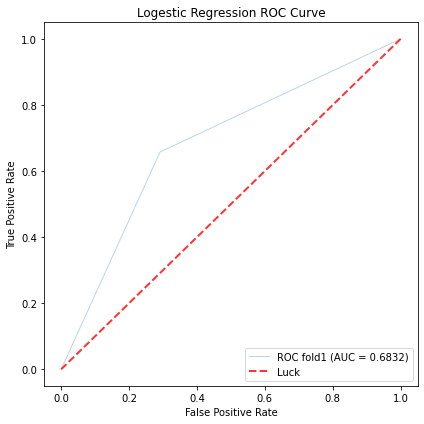

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
score = roc_auc_score(y_test, y_pred_lr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold%d (AUC = %0.4f)" %(1, score))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logestic Regression ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
#plt.savefig("lr_auc.png", bbox_inches='tight', transparent=True)
plt.show()

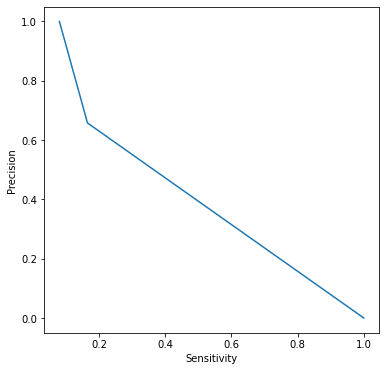

In [18]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, sensitivity, thresholds = precision_recall_curve(y_test, y_pred_lr)

plt.figure(figsize=(6,6))
plt.plot(precision, sensitivity)
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
#plt.savefig("lr_precision_recall.png", bbox_inches='tight', transparent=True)
plt.show()

##### [sommaire](#S)

### Random Forest <a class='anchor' id='IIB2'></a>

In [19]:
rf = RandomForestClassifier(n_estimators=100)

In [20]:
%%time
rf.fit(X_train, y_train)

Wall time: 6min 10s


RandomForestClassifier()

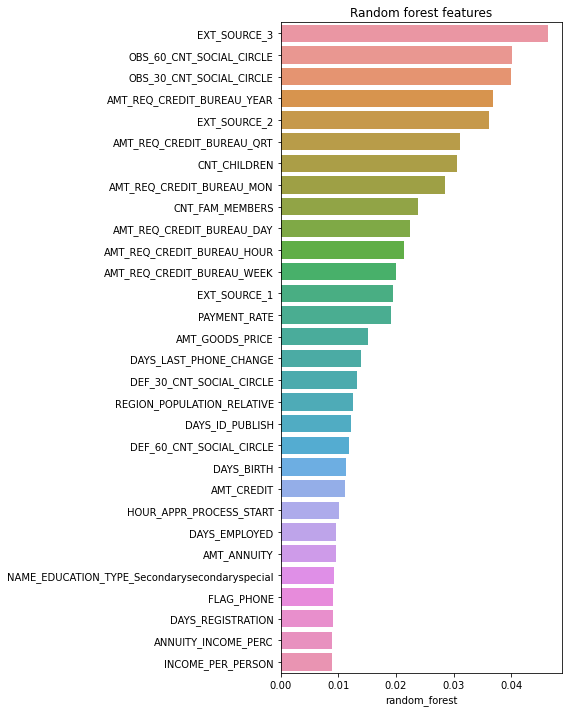

In [21]:
coefficients = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['random_forest'])
coefficients = coefficients.sort_values(by='random_forest', ascending=False)[:30]

plt.figure(figsize=(8,10))
sns.barplot(y=coefficients.index, x='random_forest', data=coefficients)
plt.title('Random forest features')
plt.tight_layout()
#plt.savefig("rf_features.png", bbox_inches='tight', transparent=True)
plt.show()

In [22]:
y_pred_rf_p = rf.predict_proba(X_test)[:,1]
y_pred_rf_b = rf.predict(X_test)

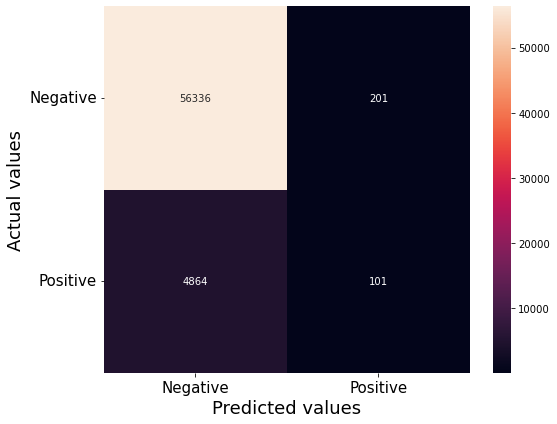

Sensitivity : 2.03 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 99.64 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 33.44 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.91


In [23]:
cm = confusion_matrix(y_test, y_pred_rf_b)

cm = confusion_matrix(y_test, y_pred_rf_b)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf_b).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted values', fontsize=18)
plt.ylabel('Actual values', fontsize=18)
plt.yticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.xticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.tight_layout()
#plt.savefig("rf_matrix.png", bbox_inches='tight', transparent=True)
plt.show()

print("Sensitivity :", format(sensitivity * 100,".2f"), "% des personnes pouvant contracter un crédit sont bien classifiées")
print("Specificity :", format(specificity * 100,".2f"), "% des personnes ne pouvant pas contracter de crédit sont bien classifiées")
print("Precision :", format(precision * 100,".2f"), "% des personnes pouvant obtenir un crédit qui sont correctement classifiées")
print("Scoring perso :", format(scoring_perso(y_test, y_pred_rf_b), ".2f"))

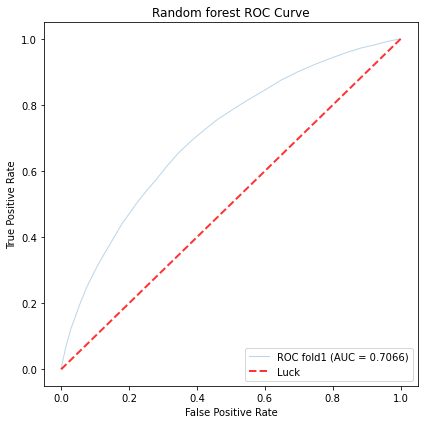

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_p)
score_rf = roc_auc_score(y_test, y_pred_rf_p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold%d (AUC = %0.4f)" %(1, score_rf))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random forest ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
#plt.savefig("rf_auc.png", bbox_inches='tight', transparent=True)
plt.show()

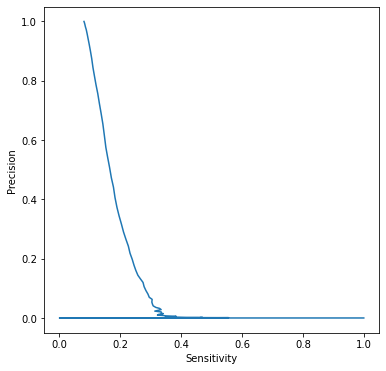

In [25]:
precision, sensitivity, thresholds = precision_recall_curve(y_test, y_pred_rf_p)

plt.figure(figsize=(6,6))
plt.plot(precision, sensitivity)
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
#plt.savefig("rf_precision_recall.png", bbox_inches='tight', transparent=True)
plt.show()

##### [sommaire](#S)

### LightGBM <a class='anchor' id='IIB3'></a>

In [26]:
lg = LGBMClassifier(n_estimators=500)

In [27]:
%%time
lg.fit(X_train, y_train)

Wall time: 49.8 s


LGBMClassifier(n_estimators=500)

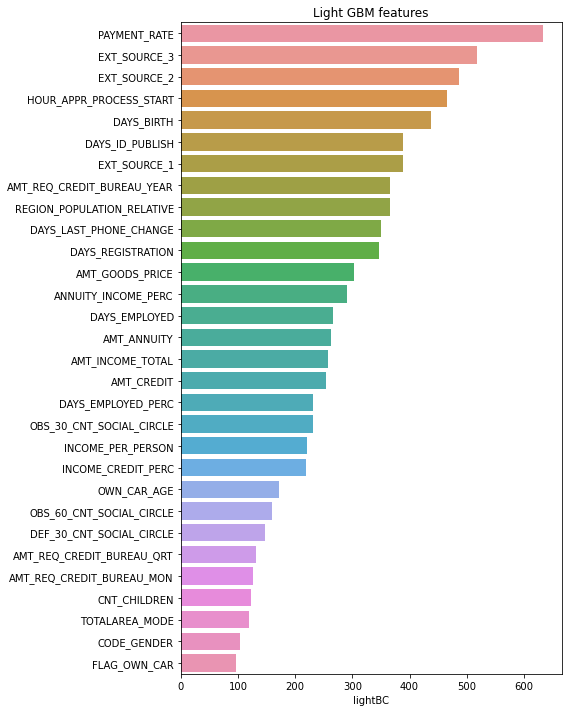

In [28]:
coefficients = pd.DataFrame(lg.feature_importances_, index=X.columns, columns=['lightBC'])
coefficients = coefficients.sort_values(by='lightBC', ascending=False)[:30]

plt.figure(figsize=(8,10))
sns.barplot(y=coefficients.index, x='lightBC', data=coefficients)
plt.title('Light GBM features')
plt.tight_layout()
#plt.savefig("lg_features.png", bbox_inches='tight', transparent=True)
plt.show()

In [29]:
coefficients.lightBC.sum()

8458

In [30]:
y_pred_lg_p = lg.predict_proba(X_test)[:,1]
y_pred_lg_b = lg.predict(X_test)

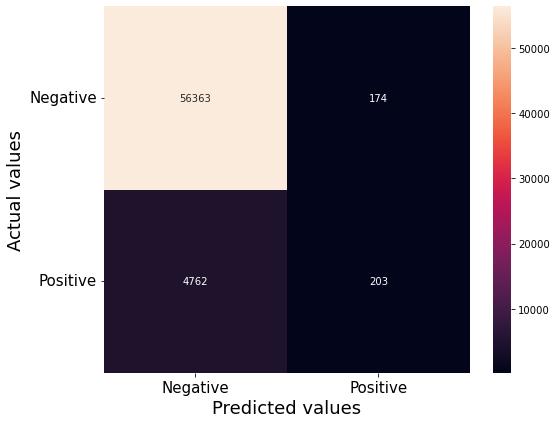

Sensitivity : 4.09 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 99.69 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 53.85 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.91


In [31]:
cm = confusion_matrix(y_test, y_pred_lg_b)

cm = confusion_matrix(y_test, y_pred_lg_b)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lg_b).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted values', fontsize=18)
plt.ylabel('Actual values', fontsize=18)
plt.yticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.xticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.tight_layout()
#plt.savefig("lg_matrix.png", bbox_inches='tight', transparent=True)
plt.show()

print("Sensitivity :", format(sensitivity * 100,".2f"), "% des personnes pouvant contracter un crédit sont bien classifiées")
print("Specificity :", format(specificity * 100,".2f"), "% des personnes ne pouvant pas contracter de crédit sont bien classifiées")
print("Precision :", format(precision * 100,".2f"), "% des personnes pouvant obtenir un crédit qui sont correctement classifiées")
print("Scoring perso :", format(scoring_perso(y_test, y_pred_lg_b), ".2f"))

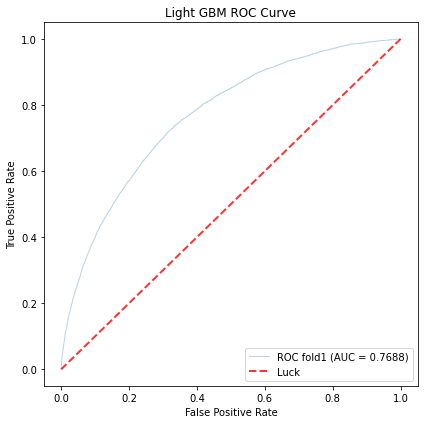

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lg_p)
score = roc_auc_score(y_test, y_pred_lg_p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold%d (AUC = %0.4f)" %(1, score))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Light GBM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
#plt.savefig("lg_auc.png", bbox_inches='tight', transparent=True)
plt.show()

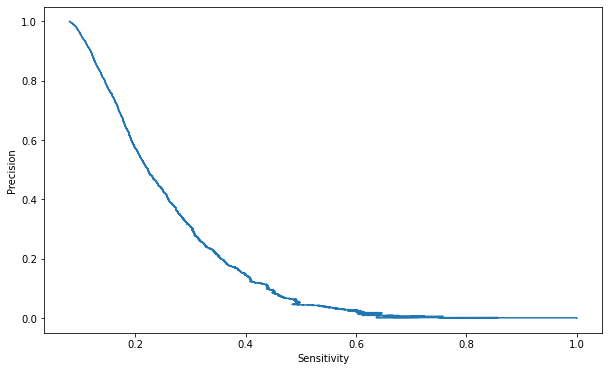

In [33]:
precision, sensitivity, thresholds = precision_recall_curve(y_test, y_pred_lg_p)

plt.figure(figsize=(10,6))
plt.plot(precision, sensitivity)
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
#plt.savefig("lg_precision_recall.png", bbox_inches='tight', transparent=True)
plt.show()

##### [sommaire](#S)

## C, Amélioration de l'algorithme <a class='anchor' id='IIC'></a>

### Recherche d'hyperparamètres par HalvingSearchCV <a class='anchor' id='IIC1'></a>

In [94]:
params_lgBMC ={
    'objective' : ['binary'],
    'learning_rate' : (0.05, 0.1),
    'num_leaves' : (50, 60),
    'n_estimators' : [1000]
}

In [95]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [98]:
hlf = HalvingGridSearchCV(estimator=LGBMClassifier(), param_grid=params_lgBMC, scoring=score_beta, cv=3, verbose=5, factor=5)

In [99]:
hlf.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 452290
max_resources_: 452290
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 4
n_resources: 452290
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END learning_rate=0.05, n_estimators=1000, num_leaves=50, objective=binary;, score=(train=3.500, test=2.710) total time= 2.3min
[CV 2/3] END learning_rate=0.05, n_estimators=1000, num_leaves=50, objective=binary;, score=(train=3.192, test=3.448) total time= 1.4min
[CV 3/3] END learning_rate=0.05, n_estimators=1000, num_leaves=50, objective=binary;, score=(train=3.194, test=3.450) total time= 1.4min
[CV 1/3] END learning_rate=0.05, n_estimators=1000, num_leaves=60, objective=binary;, score=(train=3.500, test=2.710) total time= 2.7min
[CV 2/3] END learning_rate=0.05, n_estimators=1000, num_leaves=60, objective=binary;, score=(train=3.216, test=3.451) total time= 1.6min
[CV 3/3] END learning_rate=0.05, n_estimators=10

HalvingGridSearchCV(cv=3, estimator=LGBMClassifier(), factor=5,
                    param_grid={'learning_rate': (0.05, 0.1),
                                'n_estimators': [1000], 'num_leaves': (50, 60),
                                'objective': ['binary']},
                    refit=<function _refit_callable at 0x000002A4710053A0>,
                    scoring=make_scorer(scoring_perso), verbose=5)

In [100]:
clf = hlf

In [101]:
pd.DataFrame(clf.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_num_leaves,param_objective,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0,452290,97.664837,23.338356,4.201541,0.649967,0.05,1000,50,binary,...,3.448379,3.450349,3.202798,0.348698,2,3.5,3.192328,3.193684,3.295337,0.144719
1,0,452290,112.241711,32.401953,4.580205,0.671124,0.05,1000,60,binary,...,3.450993,3.451623,3.204094,0.349614,1,3.5,3.215861,3.216209,3.310690,0.133862
2,0,452290,87.856687,17.336152,4.434055,0.811914,0.1,1000,50,binary,...,3.437793,3.441395,3.196311,0.344057,4,3.5,3.301028,3.303691,3.368240,0.093175
3,0,452290,96.748492,12.566738,4.338969,0.610362,0.1,1000,60,binary,...,3.440221,3.440479,3.196789,0.344448,3,3.5,3.339386,3.337777,3.392388,0.076096


In [102]:
params = dict(clf.best_params_)

In [103]:
lg = LGBMClassifier(learning_rate=params['learning_rate'], 
                    n_estimators=params['n_estimators'], 
                    num_leaves=params['num_leaves'], 
                    objective='binary')

In [42]:
#lg = LGBMClassifier(n_estimators=1000, learning_rate=0.1, num_leaves=50, objective='binary')

In [106]:
%%time
lg.fit(X_train, y_train)

Wall time: 1min 28s


LGBMClassifier(learning_rate=0.05, n_estimators=1000, num_leaves=60,
               objective='binary')

In [107]:
y_pred_p = lg.predict_proba(X_test)[:,1]
y_pred_b = lg.predict(X_test)

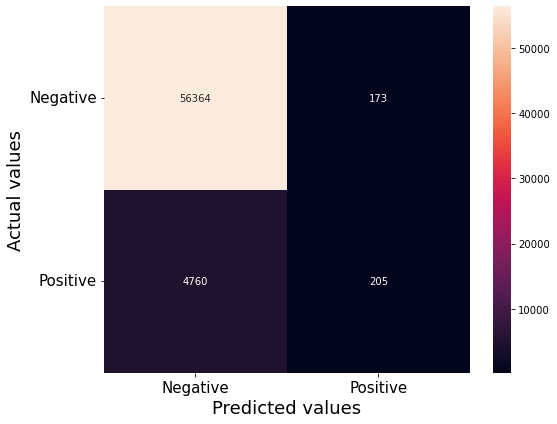

Sensitivity : 4.13 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 99.69 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 54.23 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.93


In [129]:
cm = confusion_matrix(y_test, y_pred_b)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_b).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted values', fontsize=18)
plt.ylabel('Actual values', fontsize=18)
plt.yticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.xticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.tight_layout()
plt.savefig("clf_matrix.png", bbox_inches='tight', transparent=True)
plt.show()
print("Sensitivity :", format(sensitivity * 100,".2f"), "% des personnes pouvant contracter un crédit sont bien classifiées")
print("Specificity :", format(specificity * 100,".2f"), "% des personnes ne pouvant pas contracter de crédit sont bien classifiées")
print("Precision :", format(precision * 100,".2f"), "% des personnes pouvant obtenir un crédit qui sont correctement classifiées")
print("Scoring perso :", format(scoring_perso(y_test, y_pred_b), ".2f"))

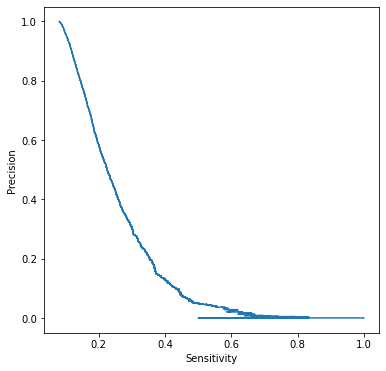

In [128]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, sensitivity, thresholds = precision_recall_curve(y_test, y_pred_p)

plt.figure(figsize=(6,6))
plt.plot(precision, sensitivity)
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
plt.savefig("clf_precision_recall.png", bbox_inches='tight', transparent=True)
plt.show()

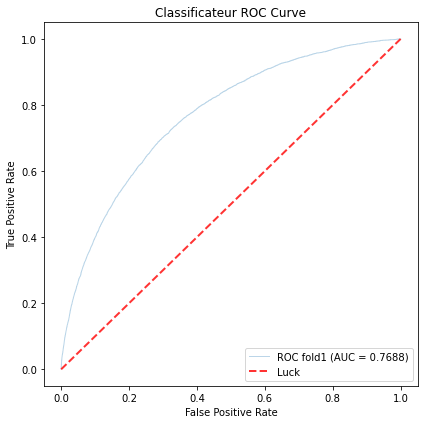

In [110]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_p)
score = roc_auc_score(y_test, y_pred_p)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold%d (AUC = %0.4f)" %(1, score))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classificateur ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
#plt.savefig("clf_auc.png", bbox_inches='tight', transparent=True)
plt.show()

In [111]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
5467,0.298972,0.701108,0.701028,0.00008,0.075064


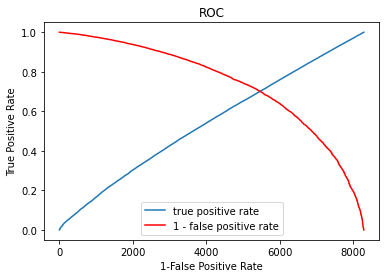

In [112]:
# Plot tpr vs 1-fpr
plt.plot(roc['tpr'], label='true positive rate')
plt.plot(roc['1-fpr'], color = 'red', label="1 - false positive rate")
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

##### [sommaire](#S)

### Recherche du treshold pertinent <a class='anchor' id='IIC2'></a>

In [113]:
threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

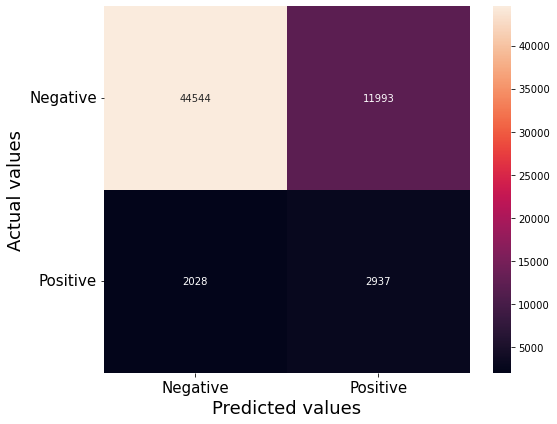

Threshold :  0.1
Sensitivity : 59.15 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 78.79 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 19.67 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : -0.51


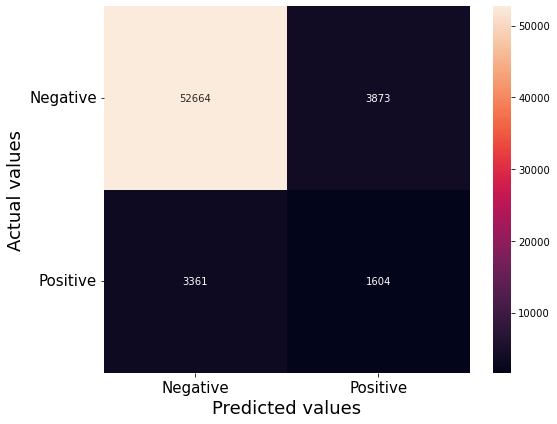

Threshold :  0.2
Sensitivity : 32.31 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 93.15 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 29.29 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.58


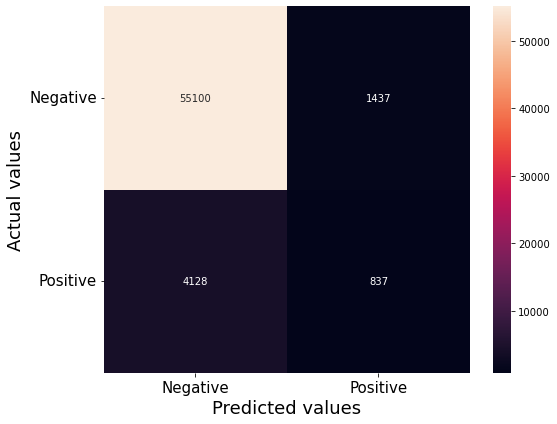

Threshold :  0.3
Sensitivity : 16.86 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 97.46 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 36.81 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.84


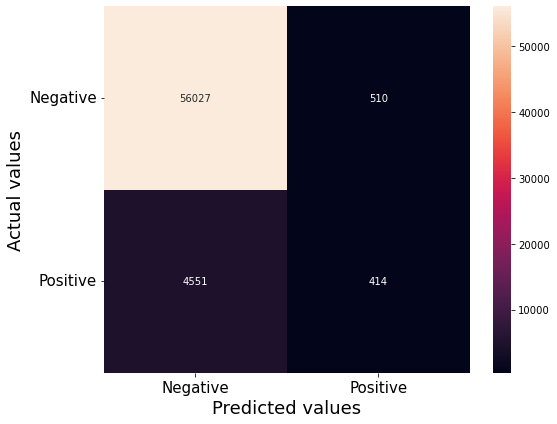

Threshold :  0.4
Sensitivity : 8.34 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 99.10 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 44.81 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.91


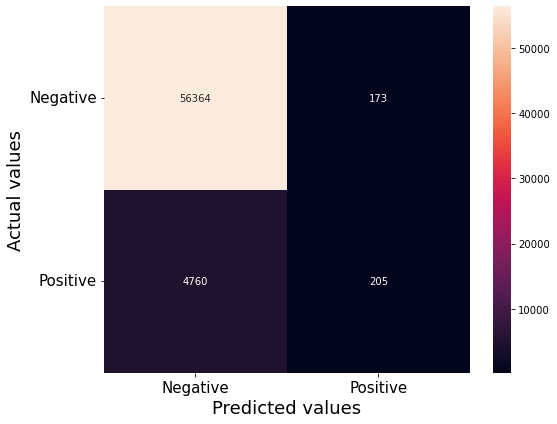

Threshold :  0.5
Sensitivity : 4.13 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 99.69 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 54.23 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.93


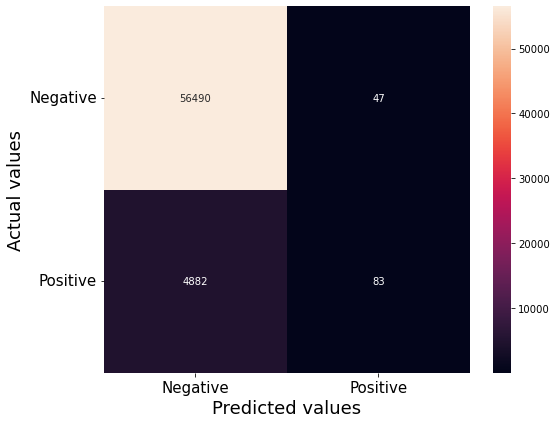

Threshold :  0.6
Sensitivity : 1.67 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 99.92 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 63.85 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.93


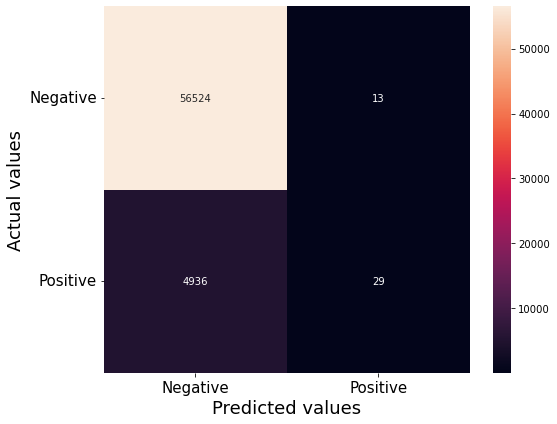

Threshold :  0.7
Sensitivity : 0.58 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 99.98 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 69.05 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.92


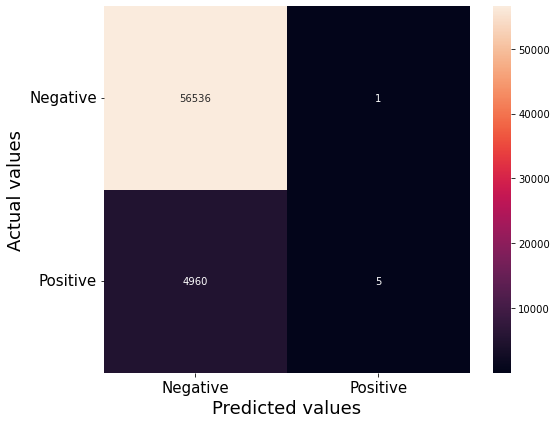

Threshold :  0.8
Sensitivity : 0.10 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 100.00 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 83.33 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.92


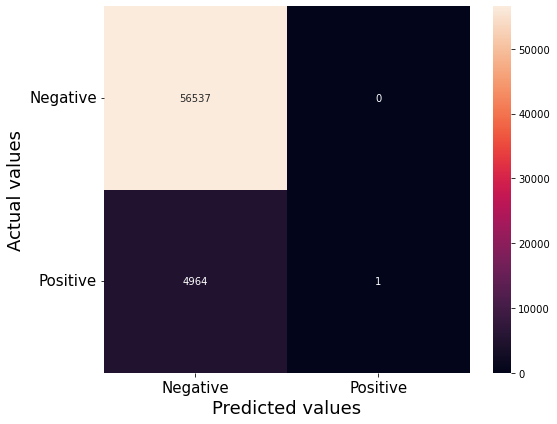

Threshold :  0.9
Sensitivity : 0.02 % des personnes pouvant contracter un crédit sont bien classifiées
Specificity : 100.00 % des personnes ne pouvant pas contracter de crédit sont bien classifiées
Precision : 100.00 % des personnes pouvant obtenir un crédit qui sont correctement classifiées
Scoring perso : 0.92


In [126]:
for i in threshold:
    y_pred = [int(j > i) for j in y_pred_p]
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted values', fontsize=18)
    plt.ylabel('Actual values', fontsize=18)
    plt.yticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
    plt.xticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
    plt.tight_layout()
    plt.savefig("clf_matrix_treeshold_{}.png".format(i), bbox_inches='tight', transparent=True)
    plt.show()
    
    print("Threshold : ", i)
    print("Sensitivity :", format(sensitivity * 100,".2f"), "% des personnes pouvant contracter un crédit sont bien classifiées")
    print("Specificity :", format(specificity * 100,".2f"), "% des personnes ne pouvant pas contracter de crédit sont bien classifiées")
    print("Precision :", format(precision * 100,".2f"), "% des personnes pouvant obtenir un crédit qui sont correctement classifiées")
    print("Scoring perso :", format(scoring_perso(y_test, y_pred), ".2f"))

##### [sommaire](#S)

## D, Analyse de l'importance des features locales <a class='anchor' id='IID'></a>

### Avec LIME <a class='anchor' id='IID1'></a>

In [53]:
import lime
from lime import lime_tabular
import random

In [54]:
cat_features = [c for c in X_train.columns if len(X_train[c].unique()) == 2]

In [55]:
cat_features

['FLAG_MOBIL',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_12',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Student',
 'NAME_FAMILY_STATUS_Unknown',
 'CC_SK_DPD_MIN',
 'CC_SK_DPD_DEF_MIN',
 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
 'CC_NAME_CONTRACT_STATUS_Demand_MIN',
 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
 'CC_NAME_CONTRACT_STATUS_Sentproposal_MIN',
 'CC_NAME_CONTRACT_STATUS_MIN',
 'CC_NAME_CONTRACT_STATUS_MAX',
 'CC_NAME_CONTRACT_STATUS_MEAN',
 'CC_NAME_CONTRACT_STATUS_SUM']

In [56]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train.values, mode='classification', 
                                              categorical_features=cat_features, feature_names=X_train.columns,
                                              class_names=y_train.values)

In [57]:
# Good prediction_1
count = 0
while count == 0:
    idx = random.choice(X_test.index)
    
    if clf.predict(X_test[X_test.index == idx])[0] == y_test[y_test.index == idx].values[0] == 0:

        print('Prediction : ', clf.predict(X_test[X_test.index == idx])[0])
        print('Actual : ', y_test[y_test.index == idx].values[0])
        print(idx)

        explanation = explainer.explain_instance(X_test[X_test.index == idx].squeeze(axis=0), 
                                                 clf.predict_proba, num_features=len(X_train.columns))
        count +=1

Prediction :  0.0
Actual :  0.0
426363


In [58]:
liste_n  = explanation.as_list()
liste_n = liste_n

features = []
values = []

for i,j in liste_n:
    features.append(i)
    values.append(j)
exp = pd.DataFrame(values, index=features, columns=['valeur'])

exp['copie'] = exp.index
exp[['copie', 'temp']] = exp.copie.str.rsplit('<',n=1, expand=True)
exp[['copie', 'temp']] = exp['copie'].str.rsplit('>',n=1, expand=True)
exp['ticks'] = exp['copie'] + " : " + round(exp['valeur'],4).astype(str)
exp.drop(['temp', 'copie'], axis=1, inplace=True)

exp_2 = exp.sort_values('valeur', ascending=True,key=abs)[-10:]

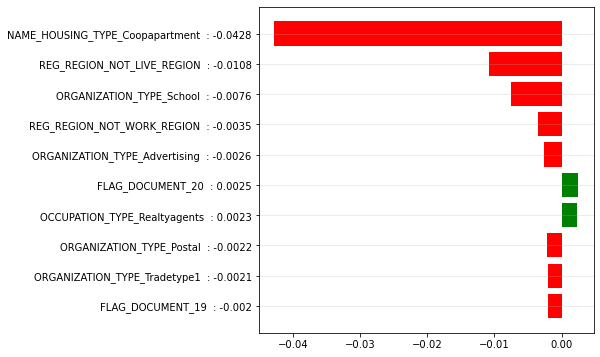

In [59]:
plt.figure(figsize=(6,6))
plt.barh(exp_2.ticks, exp_2['valeur'], color=['red' if coef < 0 else 'green' for coef in exp_2['valeur']])
plt.grid(visible=True, axis='y', alpha=0.3)
#plt.yticks([i for i in exp.valeur])
#plt.savefig("lime_pred_0.png", bbox_inches='tight', transparent=True)
plt.show()

In [60]:
exp

,valeur,ticks
NAME_HOUSING_TYPE_Coopapartment > 0.00,-0.042814,NAME_HOUSING_TYPE_Coopapartment : -0.0428
REG_REGION_NOT_LIVE_REGION > 0.00,-0.010783,REG_REGION_NOT_LIVE_REGION : -0.0108
ORGANIZATION_TYPE_School > 0.00,-0.007576,ORGANIZATION_TYPE_School : -0.0076
REG_REGION_NOT_WORK_REGION > 0.00,-0.003470,REG_REGION_NOT_WORK_REGION : -0.0035
ORGANIZATION_TYPE_Advertising <= 0.00,-0.002567,ORGANIZATION_TYPE_Advertising : -0.0026
...,...,...
ORGANIZATION_TYPE_Industrytype8 <= 0.00,0.000000,ORGANIZATION_TYPE_Industrytype8 : 0.0
FLAG_DOCUMENT_10 <= 0.00,0.000000,FLAG_DOCUMENT_10 : 0.0
NAME_FAMILY_STATUS_Singlenotmarried <= 1.00,0.000000,NAME_FAMILY_STATUS_Singlenotmarried : 0.0
NAME_FAMILY_STATUS_Unknown <= 0.00,0.000000,NAME_FAMILY_STATUS_Unknown : 0.0


In [61]:
# Good prediction_2
count = 0
while count == 0:
    idx = random.choice(X_test.index)
    
    if clf.predict(X_test[X_test.index == idx])[0] == y_test[y_test.index == idx].values[0] == 1:

        print('Prediction : ', clf.predict(X_test[X_test.index == idx])[0])
        print('Actual : ', y_test[y_test.index == idx].values[0])
        print(idx)

        explanation = explainer.explain_instance(X_test[X_test.index == idx].squeeze(axis=0), 
                                                 clf.predict_proba, num_features=len(X_train.columns))
        count +=1

Prediction :  1.0
Actual :  1.0
151287


In [62]:
liste_n  = explanation.as_list()
liste_n = liste_n

features = []
values = []

for i,j in liste_n:
    features.append(i)
    values.append(j)
exp = pd.DataFrame(values, index=features, columns=['valeur'])

exp['copie'] = exp.index
exp[['copie', 'temp']] = exp.copie.str.rsplit('<',n=1, expand=True)
exp[['copie', 'temp']] = exp['copie'].str.rsplit('>',n=1, expand=True)
exp['ticks'] = exp['copie'] + " : " + round(exp['valeur'],4).astype(str)
exp.drop(['temp', 'copie'], axis=1, inplace=True)

exp_2 = exp.sort_values('valeur', ascending=True,key=abs)[-10:]

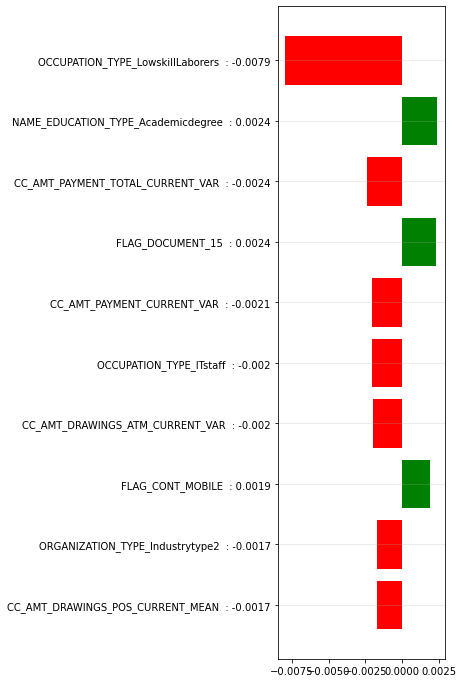

In [63]:
plt.figure(figsize=(3,12))
plt.barh(exp_2.ticks, exp_2['valeur'], color=['red' if coef < 0 else 'green' for coef in exp_2['valeur']])
plt.grid(visible=True, axis='y', alpha=0.3)
#plt.yticks([i for i in exp.valeur])
#plt.savefig("lime_pred_1.png", bbox_inches='tight', transparent=True)
plt.show()

In [64]:
# Bad prediction
count = 0
while count == 0:
    idx = random.choice(X_test.index)
    
    if clf.predict(X_test[X_test.index == idx])[0] != y_test[y_test.index == idx].values[0]:

        print('Prediction : ', clf.predict(X_test[X_test.index == idx])[0])
        print('Actual : ', y_test[y_test.index == idx].values[0])
        print(idx)

        explanation = explainer.explain_instance(X_test[X_test.index == idx].squeeze(axis=0), 
                                                 clf.predict_proba, num_features=len(X_train.columns))
        count +=1

Prediction :  0.0
Actual :  1.0
344181


In [65]:
liste_n  = explanation.as_list()
liste_n = liste_n

features = []
values = []

for i,j in liste_n:
    features.append(i)
    values.append(j)
exp = pd.DataFrame(values, index=features, columns=['valeur'])

exp['copie'] = exp.index
exp[['copie', 'temp']] = exp.copie.str.rsplit('<',n=1, expand=True)
exp[['copie', 'temp']] = exp['copie'].str.rsplit('>',n=1, expand=True)
exp['ticks'] = exp['copie'] + " : " + round(exp['valeur'],4).astype(str)
exp.drop(['temp', 'copie'], axis=1, inplace=True)

exp_2 = exp.sort_values('valeur', ascending=True,key=abs)[-10:]


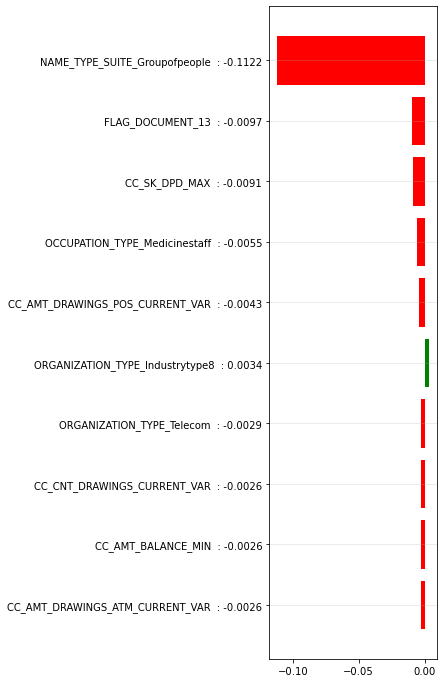

In [66]:
plt.figure(figsize=(3,12))
plt.barh(exp_2.ticks, exp_2['valeur'], color=['red' if coef < 0 else 'green' for coef in exp_2['valeur']])
plt.grid(visible=True, axis='y', alpha=0.3)
#plt.yticks([i for i in exp.valeur])
#plt.savefig("lime_pred_mistake.png", bbox_inches='tight', transparent=True)
plt.show()

##### [sommaire](#S)

### Avec SHAP <a class='anchor' id='IID2'></a>

In [134]:
import shap
import random

In [68]:
y_train_pos = y_train[y_train > 0].index
X_train_pos = X_train[X_train.index.isin(y_train_pos)]

In [69]:
explainer_sh = shap.TreeExplainer(lg, X_train)

In [70]:
shap_values = explainer_sh.shap_values(X_test, check_additivity=False)

100%|===================| 61485/61502 [24:15<00:00]        

In [135]:
count = 0

while count == 0:
    
    idx = random.randint(1,len(X_test))

    actual = int(y_test.iloc[idx])
    prediction = int(lg.predict(X_test.iloc[[idx]]))

    if actual == prediction ==1 :

        print('Obtention du crédit (actual) :', actual)
        print('Obtention du crédit (prediction) :', prediction)
        print(idx)

#        shap_values = explainer_sh.shap_values(X_test.iloc[idx])

        shap.plots._waterfall.waterfall_legacy(explainer_sh.expected_value, 
                                               shap_values[idx], 
                                               X_test.iloc[idx].values, 
                                               feature_names=X.columns,
                                              max_display=20, show=False)
        plt.savefig("shap_pred_1.png", bbox_inches='tight', transparent=True)
        plt.show()
        count +=1

Obtention du crédit (actual) : 1
Obtention du crédit (prediction) : 1
55747


NameError: name 'plt' is not defined

In [ ]:
print('Obtention du crédit (actual) :', actual)
print('Obtention du crédit (prediction) :', prediction)
print(idx)
shap.initjs()
shap.force_plot(explainer_sh.expected_value, shap_values[idx], 
                feature_names=X_test.columns, features=shap_values[idx])

In [ ]:
shap.initjs()
shap.force_plot(explainer_sh.expected_value, shap_values[idx-50:idx+50], 
                feature_names=X_test.columns, features=shap_values[idx-50:idx+50])

In [ ]:
plt.figure(figsize=(6,10))
shap.bar_plot(shap_values[idx], feature_names=X_test.columns, max_display=20)
plt.show()

#### Shap avec shap_value unique

In [ ]:
count = 0

while count == 0:
    
    idx = random.randint(1,len(X_test))

    actual = int(y_test.iloc[idx])
    prediction = int(lg.predict(X_test.iloc[[idx]]))

    if actual == prediction ==0:

        print('Obtention du crédit (actual) :', actual)
        print('Obtention du crédit (prediction) :', prediction)
        print(idx)

        shap_values_indiv = explainer_sh.shap_values(X_test.iloc[idx])

        shap.plots._waterfall.waterfall_legacy(explainer_sh.expected_value, 
                                               shap_values_indiv, 
                                               X_test.iloc[idx].values, 
                                               feature_names=X.columns,
                                              max_display=20, show=False)
        #plt.savefig("shap_pred_0.png", bbox_inches='tight', transparent=True)
        plt.show()
        count +=1

In [ ]:
import pickle

with open('explainer_shap.pkl', 'wb') as handle:
    pickle.dump(explainer_sh, handle)

##### [sommaire](#S)

# III, Export du modèle de prédiction <a class='anchor' id='III'></a>

## A, Création d'un pipeline <a class='anchor' id='IIIA'></a>

In [ ]:
from imblearn import pipeline

In [ ]:
pipeline = pipeline.Pipeline([('smote', SMOTE(sampling_strategy='minority')), 
                               ('lgBmC', LGBMClassifier(**clf.best_params_))])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
pipeline.score(X_test, y_test)

In [ ]:
y_pip = pipeline.predict_proba(X_test)[:,1]

In [ ]:
y_pred = [int(j > 0.2) for j in y_pip]

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted values', fontsize=18)
plt.ylabel('Actual values', fontsize=18)
plt.yticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.xticks(ticks=[0.5,1.5], labels=['Negative', 'Positive'], rotation=0, fontsize=15)
plt.tight_layout()
plt.show()

print("Sensitivity :", format(sensitivity * 100,".2f"), "% des personnes pouvant contracter un crédit sont bien classifiées")
print("Specificity :", format(specificity * 100,".2f"), "% des personnes ne pouvant pas contracter de crédit sont bien classifiées")
print("Precision :", format(precision * 100,".2f"), "% des personnes pouvant obtenir un crédit qui sont correctement classifiées")
print("Scoring perso :", format(scoring_perso(y_test, y_pred), ".2f"))

##### [sommaire](#S)

## B, Export avec ML Models <a class='anchor' id='IIIB'></a>

In [ ]:
from mlflow.models.signature import infer_signature

In [ ]:
signature = infer_signature(X_train, y_train)

In [ ]:
import mlflow.sklearn

In [ ]:
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

In [ ]:
with open('mlflow_model/model.pkl', 'rb') as f:
    x = pickle.load(f)

In [ ]:
# Pipeline et modèle similaire
ind = random.choice(y_test.index)

print(pipeline.predict_proba(X_test[X_test.index == ind]))
print(lg.predict_proba(X_test[X_test.index == ind]))
print(x.predict_proba(X_test[X_test.index == ind]))

In [ ]:
clf.best_params_

In [ ]:
""""

Entrée pour le dashboard ==> ID client

Création du dashboard :
- API (backend), Flasks ou FAST API (flask reco)
- APP (frontend), Dash ou Streamlite (str reco)

Installer docker pour lier front et back end

Faire tourner en local

Déployer sur le web avec Heroku

""""

##### fin de page <a class='anchor' id='fdp'></a>

##### [sommaire](#S)